# Initialization


## Importing the libraries

In [1]:
###############################################################################
#
#Importing libraries
#
import numpy as np 
import scipy.stats
import pandas as pd 
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns
import datapane as dp
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AffinityPropagation
from scipy.stats import chi2_contingency as chi2
###############################################################################
#
#Notebook options
#
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
###############################################################################

## Loading the data

In [2]:
###############################################################################
#
# Reading all the data
#
dropout = pd.read_excel(r"../Data/dropout.xls")
enrollments = pd.read_excel(r"../Data/enrollment.xls")
drinks = pd.read_excel(r"../Data/drinking_water.xls")
computers = pd.read_excel(r"../Data/computers.xls")
electricity = pd.read_excel(r"../Data/electricity.xls")
boys_toilet = pd.read_excel(r"../Data/boys_toilet.xls")
girls_toilet = pd.read_excel(r"../Data/girls_toilet.xls")
ptr= pd.read_excel(r"../Data/pupil_teacher.xls")
###############################################################################

# Data preparation

In [3]:
###############################################################################
#
# def returner(xx)
# Input: 
# xx= input dataframe of different factors
# 
# 1. Calculate the aggregate score for that factor for a particular state over three years
# 2. Returns the data as a dataframe with the state as the index
#
###############################################################################

def returner(xx):
    x=[]
    for i in range(36):
        x.append([xx['State'].iloc[3*i],xx[['State','All Schools']].iloc[3*i:i*3+3].mean()[0]])  
    x=pd.DataFrame(x)
    x.set_index(0, inplace=True)
    x.index.name='State'
    return x

In [4]:
enrollments['Higher_Secondary_Boys']=enrollments['Higher_Secondary_Boys'].astype('float')
enrollments['Higher_Secondary_Girls']=enrollments['Higher_Secondary_Girls'].astype('float')
enrollments['Higher_Secondary_Total']=enrollments['Higher_Secondary_Total'].astype('float')   

drinks=returner(drinks)
drinks.columns=['Drinking water']
electricity=returner(electricity)
electricity.columns=['Electricity']
computers=returner(computers)
computers.columns=["Computer"]
boys_t=returner(boys_toilet)
boys_t.columns=['Boys toilet']
girls_t=returner(girls_toilet)
girls_t.columns=['Girls toilet']

factors=pd.concat([drinks,electricity,computers,boys_t,girls_t],axis=1)
factors.reset_index(inplace=True)

In [5]:
# Extracting the names of the states

states=[]
for i in range(36):
    states.append(dropout.State.iloc[3*i])
states=pd.DataFrame(states, columns=['State'])

In [6]:
###############################################################################
#
# def create_aggregate(inp)
# 
# Input: input data of enrollments and dropouts
#
# 1. Drop the state and year columns
# 2. Aggregate the data over 3 years and return it 
#
################################################################################

def create_aggregate(inp):
    inp.drop(['State','Year'],axis=1,inplace=True)

    x=pd.DataFrame()
    for i in range(36):
        x[i]=inp.iloc[3*i+0:i*3+3,:].mean()
    x=x.transpose() 
    return x

In [7]:
dropouts_x = create_aggregate(dropout)
enrollments_x=create_aggregate(enrollments)

# Data exploration

In [8]:
print("\n Correlation between enrollment rates at different stages of schooling\n")
enrollments[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']].corr(method='spearman').style.background_gradient(cmap='coolwarm')


 Correlation between enrollment rates at different stages of schooling



,Primary_Total,Upper_Primary_Total,Secondary_Total,Higher_Secondary_Total
Primary_Total,1.000000,0.691324,0.122769,-0.214995
Upper_Primary_Total,0.691324,1.000000,0.513059,0.076736
Secondary_Total,0.122769,0.513059,1.000000,0.660590
Higher_Secondary_Total,-0.214995,0.076736,0.660590,1.000000


### Observations
* There is moderate positive correlation between `primary` and `upper primary` dropouts
* There is moderate positive correlation between `secondary` and `higher secondary` dropouts

Probably in similar states students dropout during the lower classes, and in other similar states the dropout rate is higher in the upper classes.

In [9]:
print("\n Correlation between dropout rates at different stages of schooling\n")
dropout[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']].corr(method='spearman').style.background_gradient(cmap='coolwarm')


 Correlation between dropout rates at different stages of schooling



,PRIMARY_TOTAL,UPPER_PRIMARY_TOTAL,SECONDARY_TOTAL,HRSECONDARY_TOTAL
PRIMARY_TOTAL,1.000000,0.748033,0.384132,-0.255152
UPPER_PRIMARY_TOTAL,0.748033,1.000000,0.605983,-0.144547
SECONDARY_TOTAL,0.384132,0.605983,1.000000,-0.183079
HRSECONDARY_TOTAL,-0.255152,-0.144547,-0.183079,1.000000


### Observations

* Dropouts in `primary` and `upper primary` are positively correlated. We need to do further analysis.

Text(0.5, 0.98, 'Analysis on dropout and enrollment rates')

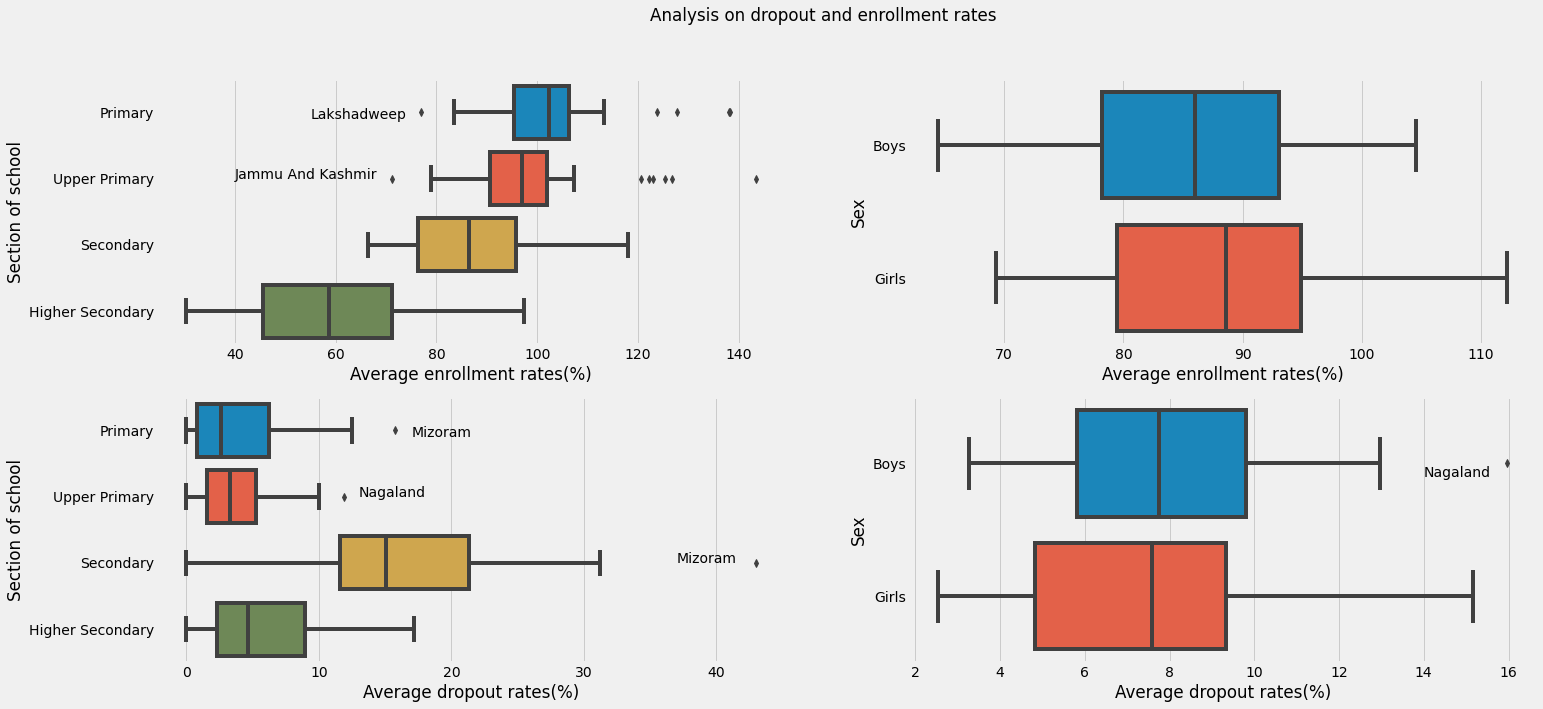

In [10]:
prim=['Primary']*36
uprim=['Upper Primary']*36
sec=['Secondary']*36
usec=['Higher Secondary']*36
lis=prim+uprim+sec+usec
lis
datas=pd.DataFrame({'values':pd.concat([enrollments_x['Primary_Total'],enrollments_x['Upper_Primary_Total'],enrollments_x['Secondary_Total'],enrollments_x['Higher_Secondary_Total']],axis=0), 'ID':lis, 'State':list(states['State'])*4})

enrollments_boys=(enrollments_x['Primary_Boys']+enrollments_x['Upper_Primary_Boys']+enrollments_x['Secondary_Boys']+enrollments_x['Higher_Secondary_Boys'])/4
enrollments_girls=(enrollments_x['Primary_Girls']+enrollments_x['Upper_Primary_Girls']+enrollments_x['Secondary_Girls']+enrollments_x['Higher_Secondary_Girls'])/4
boys=['Boys']*36
girls=['Girls']*36
sex=boys+girls
enrolls=pd.concat([enrollments_boys,enrollments_girls],axis=0)
datassex1=pd.DataFrame({'Enrollments':enrolls,'Sex':sex,'State':list(states['State'])*2})


datass=pd.DataFrame({'values':pd.concat([dropouts_x['PRIMARY_TOTAL'],dropouts_x['UPPER_PRIMARY_TOTAL'],dropouts_x['SECONDARY_TOTAL'],dropouts_x['HRSECONDARY_TOTAL']],axis=0), 'ID':lis,'State':list(states['State'])*4})

dropouts_boys=(dropouts_x['PRIMARY_BOYS']+dropouts_x['UPPER_PRIMARY_BOYS']+dropouts_x['SECONDARY_BOYS']+dropouts_x['HRSECONDARY_BOYS'])/4
dropouts_girls=(dropouts_x['PRIMARY_GIRLS']+dropouts_x['UPPER_PRIMARY_GIRLS']+dropouts_x['SECONDARY_GIRLS']+dropouts_x['HRSECONDARY_GIRLS'])/4

drops=pd.concat([dropouts_boys,dropouts_girls],axis=0)
datassex2=pd.DataFrame({'Dropouts':drops,'Sex':sex,'State':list(states['State'])*2})

fig,ax=plt.subplots(2,2,figsize=(22,10))

sns.boxplot(x='values',y='ID',data=datas,ax=ax[0,0])
ax[0,0].set_xlabel('Average enrollment rates(%)')
ax[0,0].set_ylabel('Section of school')
#ax[0].suptitle('Comparison of enrollment rates across different sections of the school')

sns.boxplot(x='Enrollments',y='Sex',data=datassex1,ax=ax[0,1])
ax[0,1].set_xlabel('Average enrollment rates(%)')
ax[0,1].set_ylabel('Sex')
#ax[1].suptitle('Comparison of enrollment rates across sex')

sns.boxplot(x='values',y='ID',data=datass,ax=ax[1,0])
ax[1,0].set_xlabel('Average dropout rates(%)')
ax[1,0].set_ylabel('Section of school')
#plt.title('Comparison of dropout rates across different sections of the school')


sns.boxplot(x='Dropouts',y='Sex',data=datassex2,ax=ax[1,1])
ax[1,1].set_xlabel('Average dropout rates(%)')
ax[1,1].set_ylabel('Sex')

low_prim=datas.State.iloc[datas['values'][datas['ID']=='Primary'].idxmin()]
up_prim=datas.State.iloc[datas['values'][datas['ID']=='Upper Primary'].idxmin()]


p_out=datass.State.iloc[datass['values'][datass['ID']=='Primary'].idxmax()]
up_out= datass.State.iloc[datass['values'][datass['ID']=='Upper Primary'].idxmax()]
sec_out=datassex2.State.iloc[datass['values'][datass['ID']=='Primary'].idxmax()]
boys_out=datassex2.State.iloc[datassex2['Dropouts'][datassex2['Sex']=='Boys'].idxmax()]


ax[0,0].text(55,0.1,s=low_prim)
ax[0,0].text(40,1,s=up_prim)
ax[1,0].text(17,0.1,s=p_out)
ax[1,0].text(13,1,s=up_out)
ax[1,0].text(37,2,s=sec_out)
ax[1,1].text(14,0.1,s=boys_out)

plt.suptitle("Analysis on dropout and enrollment rates")

`Observation:`
* Lakshwadeep and J&K have exceptionally low enrollment rates
* Mizoram has exceptionally high dropout rates in secondary school
* Nagaland has exceptionally high dropout rates of boys

## Student to teacher ratio

In [11]:
prim=['Primary']*36
uprim=['Upper Primary']*36
sec=['Secondary']*36
usec=['Higher Secondary']*36
lis=prim+uprim+sec+usec
lis
datas=pd.DataFrame({'Mean percentage(%)':pd.concat([ptr['Primary'],ptr['Upper Primary'],ptr['Secondary'],ptr['Higher Secondary']],axis=0), 'Section of school':lis, 'State':list(states['State'])*4})

fig=px.box(data_frame=datas,x='Mean percentage(%)', y='Section of school',hover_name='State',color='Section of school', title="Student to teacher ratio")
fig.update_layout(showlegend=False)

r = dp.Report(
  dp.Markdown('Student to teacher ratio'), #add description to the report
  dp.Plot(fig) #create a chart
).publish(name='STR', visibility=dp.Visibility.PUBLIC,open=True) #Publish the report

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\datapane\client\api\__init__.py:83: UserWarning:

Deprecated, to be removed in next release, use dp.Text instead.



Publishing document and associated data - *please wait...*

Report successfully published at https://datapane.com/u/anupammisra/reports/str/ - you can edit and add additional text online

`Observations:`

* Most states lack teachers in the higher secondary school. Certain states are doing very poorly namely UP, Bihar, Jharkhand and WB

In [12]:
dropss=dropouts_x.iloc[:,[2,5,8,11]].mean(axis=1)
enrolls=enrollments_x.iloc[:,[2,5,8,11]].mean(axis=1)
ptrs=ptr.iloc[:,[1,4]].mean(axis=1)
comb=pd.DataFrame({'Enrollments(%)':enrolls,'Dropouts(%)':dropss,'student_teacher_ratio':ptrs})
figz = px.scatter(data_frame=comb, x="Enrollments(%)", y="Dropouts(%)", size="student_teacher_ratio", color=states.State, log_x=True, size_max=20, width=1000, height=500, title='Dropouts vs enrollments')
figz.update_layout(showlegend=False)
r = dp.Report(
  dp.Markdown('Overall picture of dropout, enrollment and student:teacher ratio among states'), #add description to the report
  dp.Plot(figz) #create a chart
).publish(name='Overall', visibility=dp.Visibility.PUBLIC,open=True) #Publish the report

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\datapane\client\api\__init__.py:83: UserWarning:

Deprecated, to be removed in next release, use dp.Text instead.



Publishing document and associated data - *please wait...*

Report successfully published at https://datapane.com/u/anupammisra/reports/overall/ - you can edit and add additional text online

`Observations:`

* UP has the highest student to teacher ratio. It also has low enrollment rate
* Bihar has low enrollment and high dropout rate. They also have a high student to teacher ratio.

In [13]:
retention_in_secondary = enrollments_x.Secondary_Total * (100-dropouts_x.SECONDARY_TOTAL)/100

In [14]:
col = lambda x : 1 if x<=60 else (2 if x <=80 else (3 if x<=90 else 4))

In [15]:
retention_in_secondary = pd.DataFrame(retention_in_secondary)
retention_in_secondary = pd.concat([states,retention_in_secondary],axis=1)
retention_in_secondary.columns=['State','Retention(%)']
retention_in_secondary['Retention(%)'][retention_in_secondary.State=='Chandigarh']=enrollments_x.Secondary_Total[5]
retention_in_secondary['color'] = retention_in_secondary['Retention(%)'].apply(col)

<ipython-input-15-9481177ef9aa>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
figx=px.scatter(data_frame= retention_in_secondary, x = 'Retention(%)', hover_name ='State' , color='color', color_continuous_scale='turbo',title="Retention rates in secondary school")
figx.update_layout(showlegend=False)

r2 = dp.Report(
  dp.Plot(figx) #create a chart
).publish(name='Retention', visibility=dp.Visibility.PUBLIC,open=True) #Publish the report

Publishing document and associated data - *please wait...*

Your report doesn't contain any text - did you know you can add text to your report from your browser once published?

Your report only contains a single element - did you know you can add multiple plots and tables to a report, add text to it and export directly to Medium once published?

Report successfully published at https://datapane.com/u/anupammisra/reports/retention/ - you can edit and add additional text online

## Other factors in schooling

In [17]:
factors.corr(method='spearman').style.background_gradient(cmap="coolwarm")

,Drinking water,Electricity,Computer,Boys toilet,Girls toilet
Drinking water,1.000000,0.866581,0.737629,0.746873,0.698581
Electricity,0.866581,1.000000,0.880671,0.714636,0.807742
Computer,0.737629,0.880671,1.000000,0.755184,0.796650
Boys toilet,0.746873,0.714636,0.755184,1.000000,0.882785
Girls toilet,0.698581,0.807742,0.796650,0.882785,1.000000


In [18]:
prim=['Drinking water']*36
uprim=['Electricity']*36
uuprim=['Computer']*36
sec=['Boys toilet']*36
usec=['Girls toilet']*36
lis=prim+uprim+uuprim+sec+usec

datas_facts=pd.DataFrame({'Mean percentage(%)':pd.concat([factors['Drinking water'],factors['Electricity'],factors['Computer'],factors['Boys toilet'], factors['Girls toilet']],axis=0), 'Factor':lis,'State':list(states['State'])*5})

figy=px.box(data_frame=datas_facts,x='Mean percentage(%)', y='Factor',hover_name='State',color='Factor', title="Presence of factors in school")
figy.update_layout(showlegend=False)

r = dp.Report(
  dp.Markdown('Presence of factors in school'), #add description to the report
  dp.Plot(figy) #create a chart
).publish(name='Factors', visibility=dp.Visibility.PUBLIC,open=True) #Publish the report

Publishing document and associated data - *please wait...*

Report successfully published at https://datapane.com/u/anupammisra/reports/factors/ - you can edit and add additional text online

In [19]:
stages= ['Primary','Upper_primary','Secondary','Higher_secondary']

b_t = [90.48205607,	82.0528972,	47.04252336, 57.7953271]
g_t = [93.83728972,	87.60654206, 48.00429907, 56.09971963]
e=[62.60271028,	71.00336449, 53.25831776, 74.1571028]
c=[21.07261682,	47.78841121, 33.04831776, 44.17813084]
dw=[93.69271028, 88.96682243, 65.32897196, 78.47168224]
boys_t = pd.DataFrame(b_t, index=stages, columns=["Boys toilet"])
girls_t = pd.DataFrame(g_t, index=stages, columns=["Girls toilet"])
elecs = pd.DataFrame(e, index=stages, columns=["Electricity"])
dww = pd.DataFrame(dw, index=stages, columns=["Drinking water"])
comps = pd.DataFrame(c, index=stages, columns=["Computers"])
composite=pd.concat([boys_t, girls_t,dww,elecs,comps], axis=1)

In [50]:
composite.transpose().style.background_gradient(cmap='coolwarm')

,Primary,Upper_primary,Secondary,Higher_secondary
Boys toilet,90.482056,82.052897,47.042523,57.795327
Girls toilet,93.837290,87.606542,48.004299,56.099720
Drinking water,93.692710,88.966822,65.328972,78.471682
Electricity,62.602710,71.003364,53.258318,74.157103
Computers,21.072617,47.788411,33.048318,44.178131


`Observations:`

* More than 50% states have atleast 92% schools with drinking water
* Much more schools have drinking water as compared to electricity
* Even lower percentage of schools have computer facility
* Higher percentage of schools have girls toilets as compared to boys toilets

# Hypothesis testing

## Dropouts

$$H_0 = Dropout\ rates\ of\ girls\ =\ dropout\ rates\ of\ boys$$
$$H_A = Dropout\ rates\ of\ girls\ \neq\ dropout\ rates\ of\ boys$$

$$ t = \frac{\bar X_1 - \bar X_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}} $$

In [21]:
g_m,g_sd=dropouts_girls.mean(), dropouts_girls.std()
b_m,b_sd=dropouts_boys.mean(), dropouts_boys.std()

Z = (g_m-b_m)/(g_sd**2/36+b_sd**2/36)

#find p-value for two-tailed test
s,p=scipy.stats.ttest_ind(dropouts_girls,dropouts_boys,alternative='two-sided')
s,p

(-0.9810354738258853, 0.3299538292807268)

$$There\ is\ a\ 17\%\ chance\ of\ boys'\ and\ girls'\ dropout\ rates\ being\ same. $$

In [22]:
F, p = scipy.stats.f_oneway(dropouts_x['PRIMARY_TOTAL'],dropouts_x['UPPER_PRIMARY_TOTAL'],dropouts_x['SECONDARY_TOTAL'],dropouts_x['HRSECONDARY_TOTAL'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=45.282, p=0.000


## Enrollments

$$H_0 = Enrollment\ rates\ of\ girls\ =\ enrollment\ rates\ of\ boys$$
$$H_A = Enrollment\ rates\ of\ girls\ \neq\ enrollment\ rates\ of\ boys$$

In [23]:
g_m,g_sd=enrollments_girls.mean(), enrollments_girls.std()
b_m,b_sd=enrollments_boys.mean(), enrollments_boys.std()

Z = (g_m-b_m)/(g_sd**2/36+b_sd**2/36)

#find p-value for two-tailed test
s,p=scipy.stats.ttest_ind(enrollments_girls,enrollments_boys,alternative='two-sided')
s,p

(0.9242406257489818, 0.35853619885206833)

$$There\ is\ a\ 72\%\ chance\ of\ boys'\ and\ girls'\ enrollment\ rates\ being\ same.$$

$$ANOVA\\ H_0\ =\ Enrollment\ rates\ are\ the\ same\ in\ primary,\ upper\ primary,\ secondary\ and\ higher\ secondary \\ H_A\ =\ Enrollment\ rates\ are\ different\ in\ primary,\ upper\ primary,\ secondary\ and\ higher\ secondary$$

In [24]:
F, p = scipy.stats.f_oneway(enrollments_x['Primary_Total'],enrollments_x['Upper_Primary_Total'],enrollments_x['Secondary_Total'],enrollments_x['Higher_Secondary_Total'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=56.868, p=0.000


## Student to teacher ratio

$$ANOVA\\ H_0\ =\ Student\ to\ teacher\ ratio\ is\ the\ same\ in\ primary,\ upper\ primary,\ secondary\ and\ higher\ secondary \\ H_A\ =\ Student\ to\ teacher\ ratio\ is\ different\ in\ primary,\ upper\ primary,\ secondary\ and\ higher\ secondary$$

In [25]:
F, p = scipy.stats.f_oneway(ptr['Primary'],ptr['Upper Primary'],ptr['Secondary'],ptr['Higher Secondary'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=12.850, p=0.000


$$The\ student\ to\ teacher\ ratio\ is\ different\ in\ primary,\ upper\ primary,\ secondary\ and\ higher\ secondary\$$

## Other factors

$$Chi^2\\ H_0\ =\ Presence\ of\ different\ factors\ is\ independent\ of\ the\ section\ of\ the\ school \\ H_A\ =\ Presence\ of\ different\ factors\ is\ dependent\ on\ the\ section\ of\ the\ school$$

In [52]:
from scipy.stats import chi2_contingency as chi2
stat,p,dof,exp=chi2(composite)
stat,p,dof

(28.07022052987094, 0.005402667046801284, 12)

In [26]:
F, p = scipy.stats.f_oneway(factors['Drinking water'],factors['Electricity'],factors['Computer'],factors['Boys toilet'],factors['Girls toilet'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=53.836, p=0.000


$$The\ presence\ of\ different\ factors\ is\ different\ in\ schools$$

# Analysis

In [30]:
#ptr['average ptr']=(ptr['Primary']+ptr['Upper Primary']+ptr['Secondary']+ptr['Higher Secondary'])/4
ptr.drop(['State'],axis=1,inplace=True)

In [31]:
#Only keeping totals for overall analysis

dropouts_x=dropouts_x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']]
enrollments_x=enrollments_x[['Primary_Total', 'Upper_Primary_Total', 'Secondary_Total','Higher_Secondary_Total']]
factors.drop(['State'],axis=1,inplace=True)

In [32]:
#Creating dataset for overall analysis
dataset=pd.concat([dropouts_x,enrollments_x,factors,ptr],axis=1)
cols=[]
for col in dataset.columns[:4]:
    cols.append("Dropout-"+col[:-6])
for col in dataset.columns[4:8]:
    cols.append("Enrollments-"+col[:-6])
for col in dataset.columns[8:13]:
    cols.append(col)  
for col in dataset.columns[13:17]:
    cols.append("PTR-"+col)   
dataset.columns=cols


In [33]:
dataset.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,Dropout-PRIMARY,Dropout-UPPER_PRIMARY,Dropout-SECONDARY,Dropout-HRSECONDARY,Enrollments-Primary,Enrollments-Upper_Primary,Enrollments-Secondary,Enrollments-Higher_Secondary,Drinking water,Electricity,Computer,Boys toilet,Girls toilet,PTR-Primary,PTR-Upper Primary,PTR-Secondary,PTR-Higher Secondary
Dropout-PRIMARY,1.000000,0.808626,0.433988,-0.326441,0.546122,0.140328,-0.348632,-0.428581,-0.807090,-0.735675,-0.594915,-0.553430,-0.504931,-0.103060,-0.227747,-0.015009,0.140097
Dropout-UPPER_PRIMARY,0.808626,1.000000,0.684685,-0.245976,0.491634,0.171943,-0.469755,-0.649678,-0.627836,-0.607732,-0.532561,-0.571282,-0.464949,0.043657,-0.120018,0.097753,0.234128
Dropout-SECONDARY,0.433988,0.684685,1.000000,-0.314359,0.302703,0.020849,-0.551866,-0.945431,-0.437114,-0.541753,-0.540026,-0.473535,-0.391753,0.275853,0.134956,0.188422,0.249324
Dropout-HRSECONDARY,-0.326441,-0.245976,-0.314359,1.000000,-0.139472,0.096330,0.235673,0.285383,0.260864,0.469375,0.459240,0.358763,0.403611,-0.355863,-0.370273,-0.227721,-0.288338
Enrollments-Primary,0.546122,0.491634,0.302703,-0.139472,1.000000,0.725354,0.090862,-0.214672,-0.596135,-0.498712,-0.433719,-0.393690,-0.286598,-0.004121,-0.086150,0.014167,-0.087959
Enrollments-Upper_Primary,0.140328,0.171943,0.020849,0.096330,0.725354,1.000000,0.461776,0.062548,-0.272681,-0.144330,-0.138739,-0.082936,0.047423,-0.103155,-0.108686,0.032069,-0.276497
Enrollments-Secondary,-0.348632,-0.469755,-0.551866,0.235673,0.090862,0.461776,1.000000,0.690090,0.307990,0.459279,0.435779,0.344108,0.442526,-0.473149,-0.297341,-0.319789,-0.650354
Enrollments-Higher_Secondary,-0.428581,-0.649678,-0.945431,0.285383,-0.214672,0.062548,0.690090,1.000000,0.417526,0.525774,0.538481,0.404507,0.371134,-0.359562,-0.188397,-0.230279,-0.327495
Drinking water,-0.807090,-0.627836,-0.437114,0.260864,-0.596135,-0.272681,0.307990,0.417526,1.000000,0.866581,0.737629,0.746873,0.698581,0.081238,0.163368,0.009285,-0.135139
Electricity,-0.735675,-0.607732,-0.541753,0.469375,-0.498712,-0.144330,0.459279,0.525774,0.866581,1.000000,0.880671,0.714636,0.807742,-0.098259,-0.072207,-0.270940,-0.298388


### Observations

* Dropouts are negatively correlated with factors. Children need more care. They need drinking water because they play a lot. If there isn't electricity, India primarily being a tropical country,discourage them to come to schools. WRITE BETTER AND FOR THE OTHER POINTS
* Correlation with dropouts reduces with increasing age of students
* Same thing observed in enrollments

In [34]:
drinks.head()

,Drinking water
State,
Andaman & Nicobar Islands,99.403333
Andhra Pradesh,93.153333
Arunachal Pradesh,80.633333
Assam,83.290000
Bihar,93.233333


## Checking feature importance

In [35]:
#Using SVD to find feature importance

vals=np.array(dataset)
u,sig,v_t=np.linalg.svd(vals)
feature_imp=pd.Series(sig,index=list(dataset.columns))
feature_imp.index.name="Feature"
feature_imp.name="Explained variance"
var_exp=pd.DataFrame(feature_imp)
tot=var_exp['Explained variance'].sum()
var_exp['Explained variance'] = var_exp['Explained variance']/tot*100
var_exp.sort_values(['Explained variance'],ascending=False,inplace=True)

exp_var=[]
for i in range(1,var_exp.shape[0]+1):
    exp_var.append(var_exp['Explained variance'].iloc[0:i].sum())
pd.concat([var_exp,pd.DataFrame(exp_var,index=var_exp.index, columns=['Cumulative explained variance'])],axis=1)

,Explained variance,Cumulative explained variance
Feature,,
Dropout-PRIMARY,63.915774,63.915774
Dropout-UPPER_PRIMARY,9.863972,73.779746
Dropout-SECONDARY,5.872573,79.652319
Dropout-HRSECONDARY,3.918029,83.570348
Enrollments-Primary,3.517997,87.088345
Enrollments-Upper_Primary,2.809554,89.897899
Enrollments-Secondary,2.136175,92.034074
Enrollments-Higher_Secondary,1.597391,93.631465
Drinking water,1.328203,94.959668


`Observations`:

* All the dropout and enrollment features explain enough variance according to the Kaizen criteria
* Among the different factors, "Drinking water" and "Electricity" explain enough variance according to the Kaizen criteria

Dropout rates in `primary` school define the maximum difference in education between the states

In [36]:
mm=MinMaxScaler()
#Lower the better. So we are subtracting the dropout rates from 100% to get the retention rate
#We are diving the PTR by 1 as lower is better
datasets=dataset.copy()
datasets['Dropout-PRIMARY']=100-datasets['Dropout-PRIMARY']
datasets['Dropout-UPPER_PRIMARY']=100-datasets['Dropout-UPPER_PRIMARY']
datasets['Dropout-SECONDARY']=100-datasets['Dropout-SECONDARY']
datasets['Dropout-HRSECONDARY']=100-datasets['Dropout-HRSECONDARY']
datasets['PTR-Primary']=1/datasets['PTR-Primary']
datasets['PTR-Upper Primary']=1/datasets['PTR-Upper Primary']
datasets['PTR-Secondary'] =1/datasets['PTR-Secondary']
datasets['PTR-Higher Secondary'] =1/datasets['PTR-Higher Secondary']

datasets[['Dropout-PRIMARY','Dropout-UPPER_PRIMARY','Dropout-SECONDARY','Dropout-HRSECONDARY']].replace({np.inf:0},inplace=True)
#Because dividing by 0 makes them 0

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Overall ranking of states

In [37]:
#Aggregating the scores from all the features
states['Overall score']=datasets.mean(axis=1)
print('\n Overall rank of states based on dropout rates, enrollment rates, student:teacher ratio and other factors \n')
states.set_index('State').sort_values(['Overall score'],ascending=False) 


 Overall rank of states based on dropout rates, enrollment rates, student:teacher ratio and other factors 



,Overall score
State,
Delhi,75.715240
Lakshadweep,74.375553
Kerala,73.349588
Chandigarh,73.321496
Sikkim,72.376044
Puducherry,71.983355
Himachal Pradesh,71.253593
Tamil Nadu,70.800147
Goa,70.517515


# Finding out if there are any outliers

In [38]:
px.box(data_frame=states, x='Overall score', hover_name='State',title='Overall scoring of states')

## Clustering and visualizing the data on the basis of top three features

In [39]:
db=AffinityPropagation()
db.fit(datasets.iloc[:,:-14])
labels=list(db.labels_)

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning:

'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.



In [40]:
figtot = px.scatter_3d(dataset, y='Dropout-PRIMARY', z='Dropout-UPPER_PRIMARY', x='Dropout-SECONDARY',color=labels,  color_continuous_scale='turbo',opacity=0.7,text=states['State'], title='Visualizing performance of states in the education sector')
figtot.update_layout(width=1200, height=520)

r = dp.Report(
  dp.Plot(figtot) #create a chart
).publish(name='STR', visibility=dp.Visibility.PUBLIC,open=True) #Publish the report


Publishing document and associated data - *please wait...*

Your report doesn't contain any text - did you know you can add text to your report from your browser once published?

Your report only contains a single element - did you know you can add multiple plots and tables to a report, add text to it and export directly to Medium once published?

Report successfully published at https://datapane.com/u/anupammisra/reports/str/ - you can edit and add additional text online

https://towardsdatascience.com/unsupervised-machine-learning-affinity-propagation-algorithm-explained-d1fef85f22c8

In [41]:
figtot.show()